In [1]:
import numpy as np 
import pandas as pd 

import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import json
import random
from PIL import Image
from sklearn.model_selection import train_test_split

version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from tokenizers import BertWordPieceTokenizer


In [2]:
! pip install transformers

# Data Preparation

In [3]:
IMAGES_PATH="/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"

CAPTIONS_PATH="/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

#number of unique words in vocab
vocab_length=25000

In [4]:
df=pd.read_csv(CAPTIONS_PATH,on_bad_lines="skip",sep="|")
df=df.dropna()
df.columns =df.columns.str.strip() #Purpose: Removes leading and trailing whitespace from all column name

In [5]:
# creating a new column and storing each image path in that
df["image_path"]=df["image_name"].apply(lambda x: os.path.join(IMAGES_PATH,x))

import re
#adding [start] and [end] while converting the comments in lowercase and remove punctuations and symbols
# \w any word character
# \s any whitespace
# [^\w\s]--> match any character that is not a letter,digit, underscore or whitespace
df["preprocessed_comments"]= df["comment"].apply(lambda x: "[START]" + re.sub(r'[^\w\s]','',x.lower())+ "[END]")

In [6]:
df.head()

,image_name,comment_number,comment,image_path,preprocessed_comments
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two young guys with shaggy hair look a...
1,1000092795.jpg,1,"Two young , White males are outside near many...",/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two young white males are outside nea...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two men in green shirts are standing i...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] a man in a blue shirt standing in a ga...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two friends enjoy time spent together ...


In [7]:
df.iloc[0]['comment']

' Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [8]:
df.iloc[0]['preprocessed_comments']

'[START] two young guys with shaggy hair look at their hands while hanging out in the yard [END]'

In [9]:
## Train test and validation split

def train_valid_test_split(data,validation_split_ratio=0.1,test_split_ratio=0.1,shuffle=True):

    if(shuffle):
        data = data.sample(frac=1).reset_index(drop=True)

    train_split, validation_test_split = train_test_split(data,test_size = validation_split_ratio+test_split_ratio, random_state=42)
    validation_split, test_split = train_test_split(validation_test_split, test_size = test_split_ratio / (validation_split_ratio+test_split_ratio), random_state=42)
    return train_split, validation_split, test_split

train_data, validation_data, test_data = train_valid_test_split(df, 0.05, 0.05, True)
print('Train data size',train_data.shape)
print('Validation data size',validation_data.shape)
print('Test data size',test_data.shape)

Train data size (143022, 5)
Validation data size (7946, 5)
Test data size (7946, 5)


# Data visualization

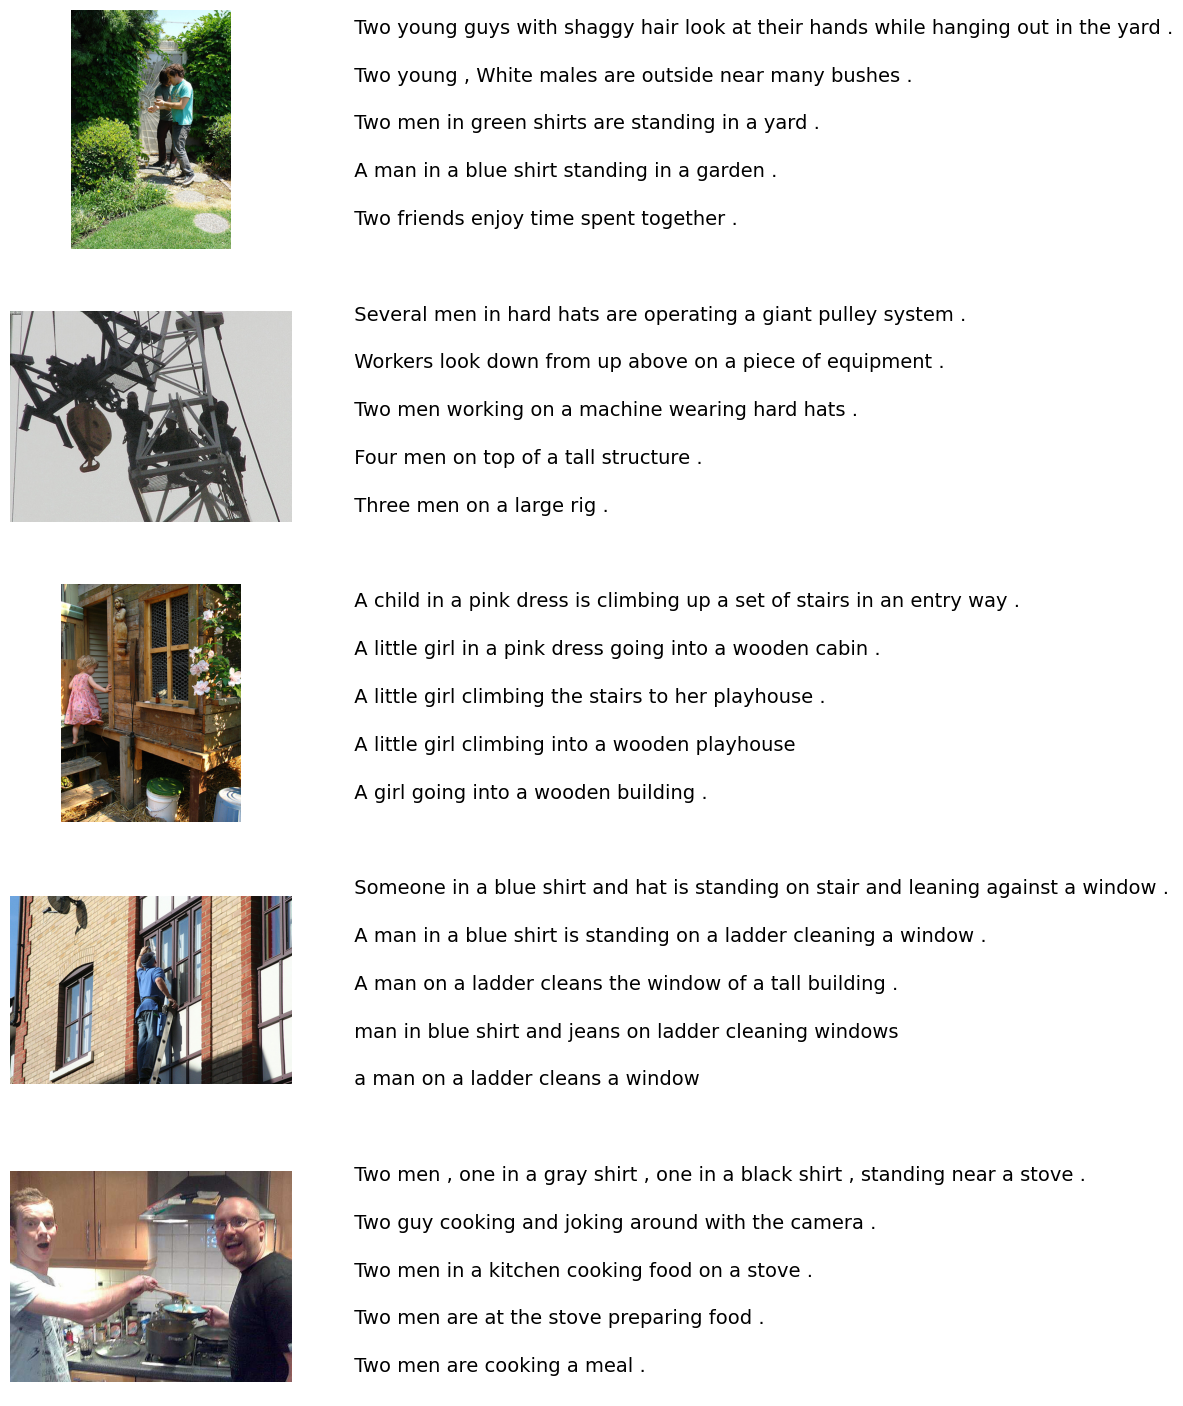

In [10]:
sample_data=df.groupby("image_path")["comment"].agg(list)
fig,axes=plt.subplots(5,2,figsize=(8,18))

#in sample_data index(row) holds the image path and all the corresponding captions are stored as a list
for ax_row,index,sample in zip(axes,sample_data.index,sample_data):
    ax_row[0].imshow(Image.open(index))
    ax_row[0].axis("off")
    text_y=0.9
    for cap in sample:
        ax_row[1].text(0,text_y,cap,fontsize=14)
        text_y-=0.2
    ax_row[1].axis('off')
    

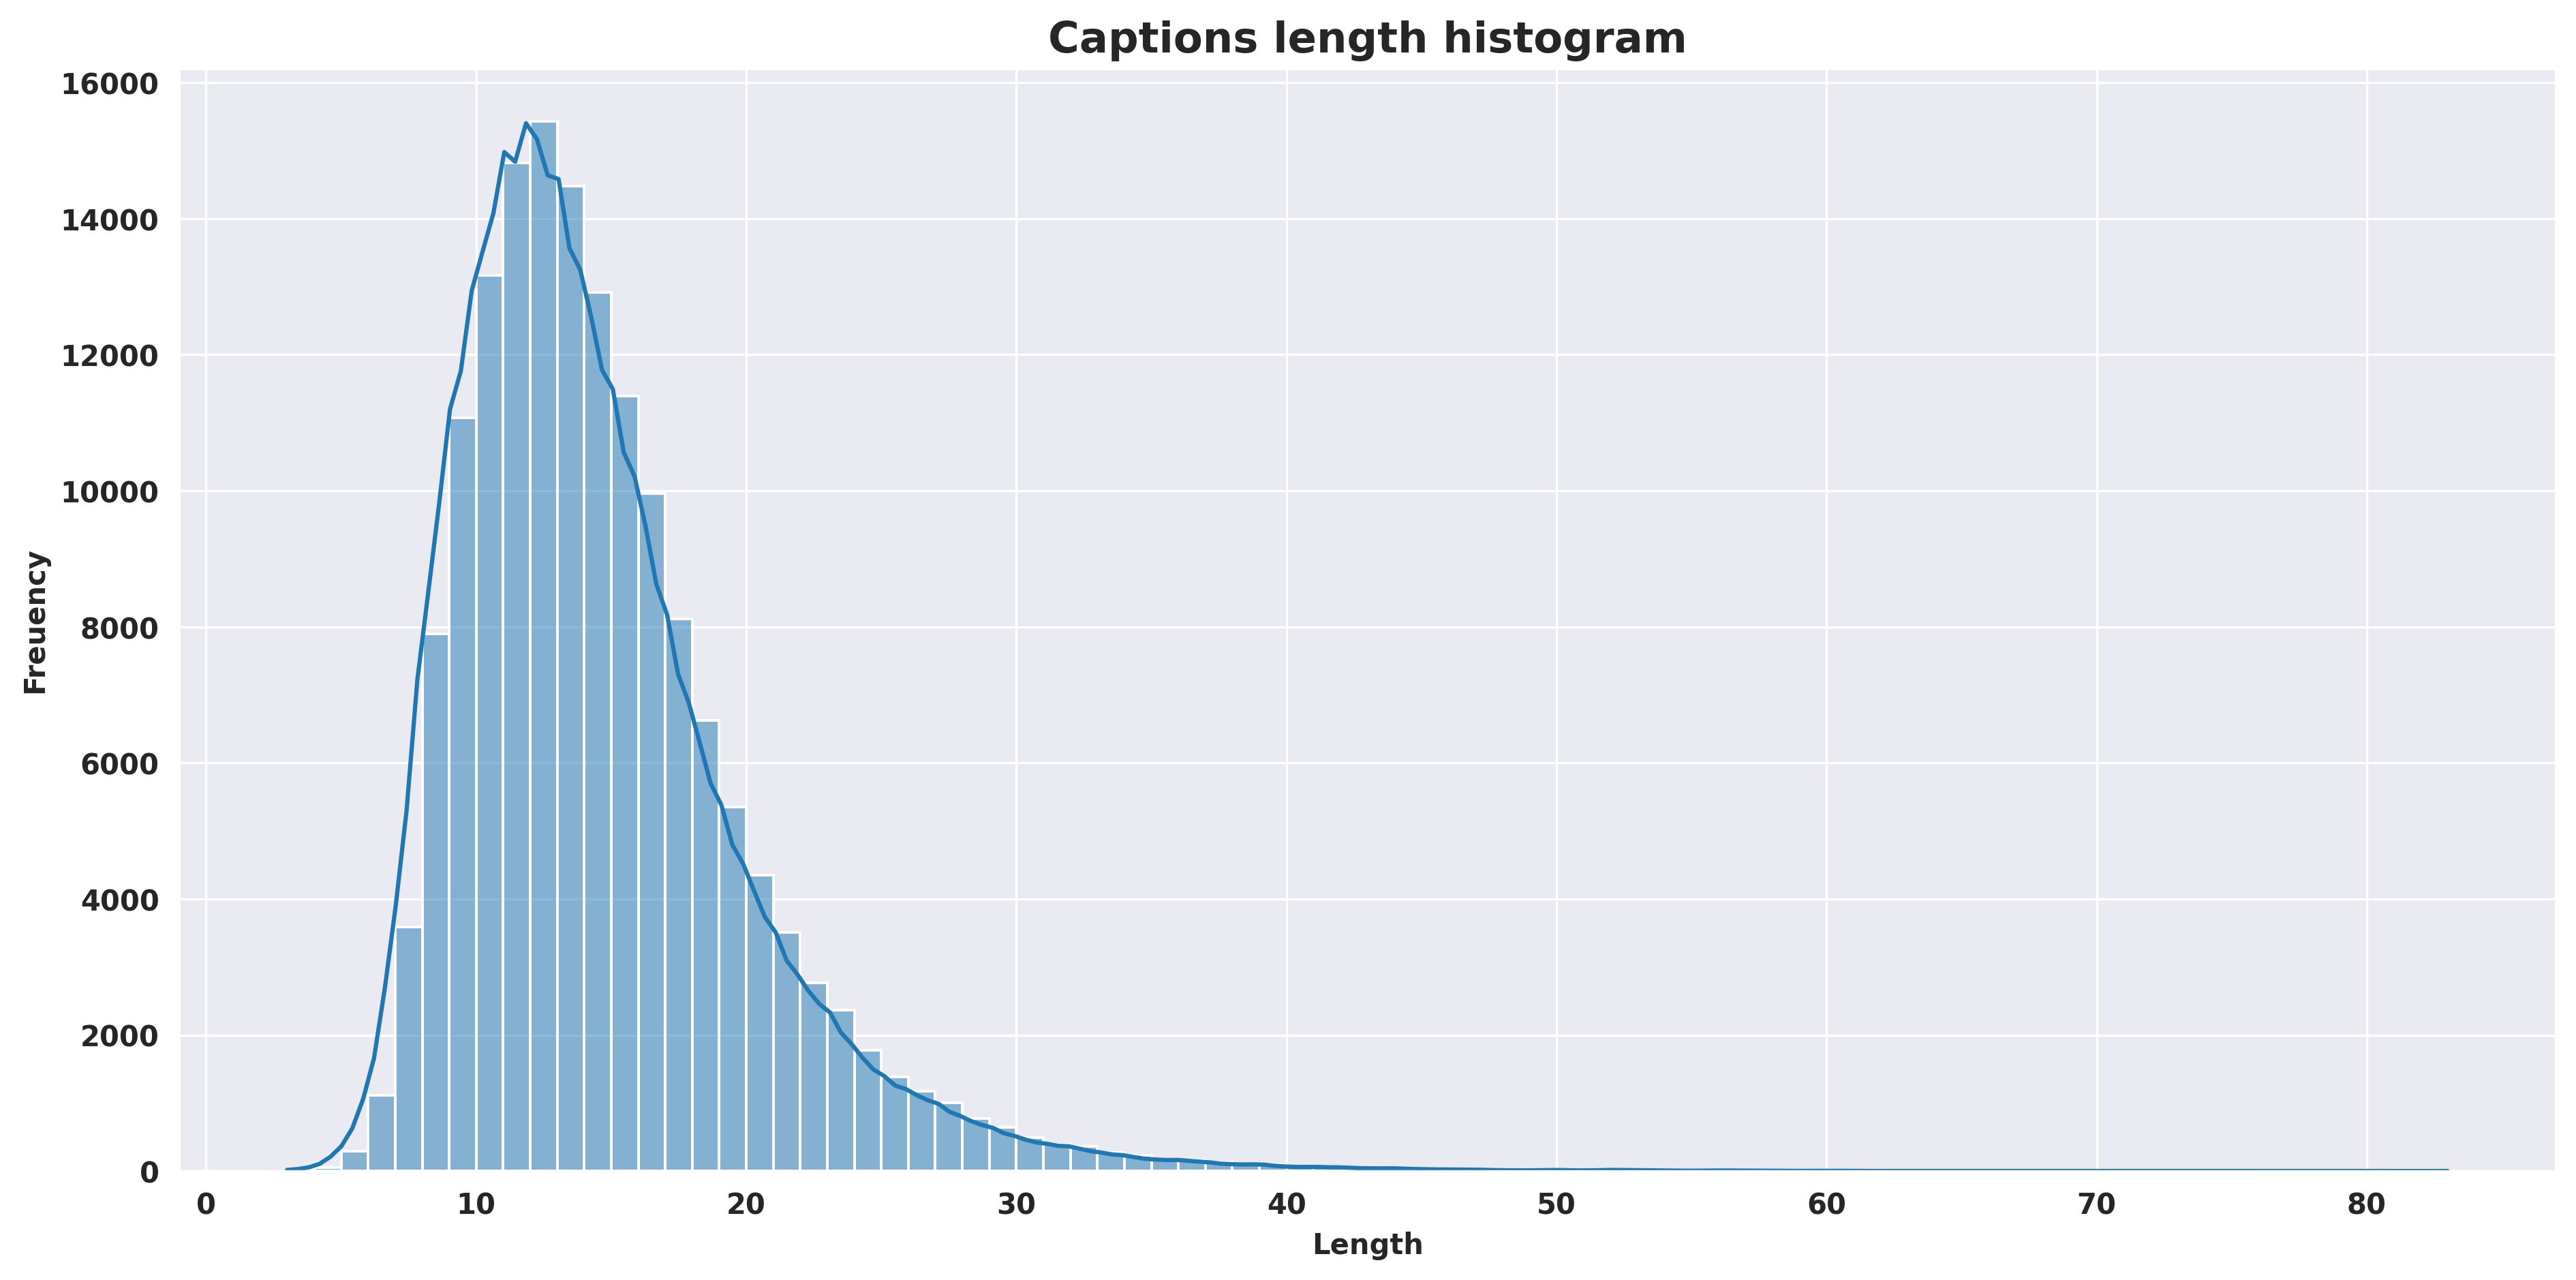

In [11]:
def captions_length(data):
    plt.figure(figsize=(15,7),dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True,binwidth=1)
    plt.title('Captions length histogram',fontsize=15,fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel("Length",fontweight='bold')
    plt.ylabel("Freuency",fontweight="bold")
    plt.show()

captions_length(df['comment'])

#from the plot we can see that words with most frequency have lenght of 15-17

In [12]:
image_stats=df.loc[:1000,"image_path"].apply(lambda x:Image.open(x).size)


In [13]:
image_stats=pd.DataFrame(image_stats.tolist(),columns=["image_width","image_height"])
image_stats.head()

,image_width,image_height
0,333,500
1,333,500
2,333,500
3,333,500
4,333,500


In [14]:
image_stats.describe()

,image_width,image_height
count,1001.000000,1001.000000
mean,458.101898,395.714286
std,65.475290,75.975880
min,320.000000,198.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,500.000000,500.000000


# Defining Bert Tokenizer

In [15]:
vocab_words=list(set(" ".join(df["preprocessed_comments"]).split()))
print(len(vocab_words))

21763


In [16]:
tokenizer=BertWordPieceTokenizer(
    unk_token="[UNK]",#unknown words
    clean_text=False,
    lowercase=False
)
tokenizer.train_from_iterator(
    df["preprocessed_comments"].tolist(),
    vocab_size=vocab_length,
    special_tokens=["[PAD]","[UNK]","[START]","[END]"]
)

# Tokenizing Sample data

In [17]:
vocab = tokenizer.get_vocab()
# Encoding a sentence
example_caption = df["preprocessed_comments"].iloc[:1]
example_tokenized_captions = tokenizer.encode_batch(example_caption)

print('caption:',example_caption[0])

for token in example_tokenized_captions[0].tokens:
    print('token:',token,"\t\tid:",vocab[token])

caption: [START] two young guys with shaggy hair look at their hands while hanging out in the yard [END]
token: [START] 		id: 2
token: two 		id: 151
token: young 		id: 183
token: guys 		id: 1027
token: with 		id: 125
token: shaggy 		id: 4095
token: hair 		id: 471
token: look 		id: 686
token: at 		id: 154
token: their 		id: 351
token: hands 		id: 616
token: while 		id: 197
token: hanging 		id: 1020
token: out 		id: 261
token: in 		id: 102
token: the 		id: 106
token: yard 		id: 1390
token: [END] 		id: 3


In [18]:
def parse_image(file_path,width,height):
    image=tf.io.read_file(file_path)
    
    #a 3D tensor of shape(height, width,3 ) with pixel values from 0-255(dtype:uint8)
    image=tf.image.decode_jpeg(image,channels=3)
    
    #converts the pixel values from integers(0-255 to floats (0.0-1.0))
    image=tf.image.convert_image_dtype(image,tf.float32)
    
    image=tf.image.resize(image,[width,height])

    # Normalization
    #transforms the pixel values from [0.0,1.0] to [-1.0,1.0]
    image=image*2.0-1.0
    return image

In [19]:
# converting the raw jpeg bytes to an actual image tensor
sample_image=tf.io.read_file("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg")
sample_image=tf.image.decode_jpeg(sample_image,channels=3)
sample_image

<tf.Tensor: shape=(500, 333, 3), dtype=uint8, numpy=
array([[[  0,   6,   4],
        [  1,   5,   4],
        [  2,   4,   3],
        ...,
        [220, 247, 255],
        [226, 255, 255],
        [225, 254, 255]],

       [[  3,   7,   6],
        [  0,   4,   3],
        [  4,   6,   5],
        ...,
        [233, 255, 255],
        [218, 250, 255],
        [225, 255, 255]],

       [[  2,   4,   3],
        [  3,   5,   4],
        [  3,   5,   4],
        ...,
        [245, 255, 255],
        [234, 255, 255],
        [215, 248, 253]],

       ...,

       [[162, 176, 143],
        [181, 189, 130],
        [128, 153,  96],
        ...,
        [105, 159,  84],
        [135, 175, 113],
        [103, 162,  68]],

       [[200, 220, 151],
        [142, 177, 113],
        [133, 160, 117],
        ...,
        [158, 189, 129],
        [157, 189, 124],
        [155, 197, 115]],

       [[143, 156,  84],
        [186, 213, 172],
        [182, 214, 149],
        ...,
        [155, 187, 12

In [20]:
sample_image=tf.image.convert_image_dtype(sample_image,tf.float32)
print(sample_image)
sample_image=tf.image.resize(sample_image,[256,256])
print(sample_image.shape)

tf.Tensor(
[[[0.         0.02352941 0.01568628]
  [0.00392157 0.01960784 0.01568628]
  [0.00784314 0.01568628 0.01176471]
  ...
  [0.86274517 0.9686275  1.        ]
  [0.8862746  1.         1.        ]
  [0.882353   0.9960785  1.        ]]

 [[0.01176471 0.02745098 0.02352941]
  [0.         0.01568628 0.01176471]
  [0.01568628 0.02352941 0.01960784]
  ...
  [0.91372555 1.         1.        ]
  [0.854902   0.9803922  1.        ]
  [0.882353   1.         1.        ]]

 [[0.00784314 0.01568628 0.01176471]
  [0.01176471 0.01960784 0.01568628]
  [0.01176471 0.01960784 0.01568628]
  ...
  [0.9607844  1.         1.        ]
  [0.9176471  1.         1.        ]
  [0.8431373  0.9725491  0.9921569 ]]

 ...

 [[0.63529414 0.6901961  0.56078434]
  [0.70980394 0.7411765  0.50980395]
  [0.5019608  0.6        0.37647063]
  ...
  [0.41176474 0.62352943 0.32941177]
  [0.5294118  0.6862745  0.4431373 ]
  [0.4039216  0.63529414 0.26666668]]

 [[0.7843138  0.86274517 0.5921569 ]
  [0.5568628  0.69411767 0

In [21]:
sample_image=sample_image*2.0 -1.0
sample_image

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[-0.9898557 , -0.9515072 , -0.96283835],
        [-0.9872969 , -0.96300155, -0.9708447 ],
        [-0.96812993, -0.95244366, -0.96646094],
        ...,
        [ 0.41123593,  0.7112994 ,  0.8132559 ],
        [ 0.75682926,  0.9749253 ,  1.        ],
        [ 0.76138854,  0.99370146,  1.        ]],

       [[-0.98936754, -0.9736813 , -0.9815244 ],
        [-0.9752792 , -0.95959294, -0.9674361 ],
        [-0.9722645 , -0.95657825, -0.9644214 ],
        ...,
        [ 0.69072366,  0.90691423,  0.9219942 ],
        [ 0.5572256 ,  0.8410723 ,  0.831166  ],
        [ 0.69743013,  0.95109713,  0.94937146]],

       [[-0.9611003 , -0.9364066 , -0.9614825 ],
        [-0.96536016, -0.9447304 , -0.96022624],
        [-0.9831639 , -0.9674776 , -0.9813256 ],
        ...,
        [-0.5386777 , -0.06541026, -0.82742774],
        [-0.7688426 , -0.28881353, -0.9548494 ],
        [-0.01033789,  0.50840116, -0.10196561]],

       ...,

     

# Defining Dataset

In [22]:
def generate_tf_dataset(image_captions_df, n_vocab=5000, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
        
    # Get the caption IDs using the tokenizer
    image_captions_df["comments_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["preprocessed_comments"])]
    
    vocab = tokenizer.get_vocab()
    
    # add the padding to short sentences and truncate long ones
    # if length of tokens of a captions is less then pad_length+2 then add padding, which is equal to the times (pad_length - len(x)+2). here 2 signifies for [START] and [END]
    # if length of tokens is greater than the pad_length+2, then only take the token till padding+1 and add the last token i.e. [END]
    image_captions_df["comments_token_ids"] = image_captions_df["comments_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_path": image_captions_df["image_path"],
        "comments_token_ids": np.array(image_captions_df["comments_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_path"], 224, 224), #image tensor
             x["comments_token_ids"][:-1],           # caption token ids(input)
             tf.range(pad_length+1, dtype='float32') # position ids
            ),
            x["comments_token_ids"]      # caption token ids(target)
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer

In [23]:
# input to above function

#Image path: "image1.jpg"
#Caption: "[START] A boy with a kite [END]"



# output 

# Inputs:
#   - Image tensor: (224, 224, 3)
#   - Caption input: [101, 1037, 2879, 2007, 1037, 10165]        (len=6)
#   - Positional:    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]              (len=6)

# Target:
#   - Caption target: [1037, 2879, 2007, 1037, 10165, 102]       (len=6)


In [24]:
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_data, n_vocab=vocab_length, pad_length=10, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)

((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.3529322 , -0.48562574, -0.65379286],
         [-0.29042304, -0.45910603, -0.6286899 ],
         [-0.6312023 , -0.77371275, -0.85260963],
         ...,
         [-0.9053234 , -0.9741254 , -0.98438007],
         [-0.9003522 , -0.95660776, -0.9759082 ],
         [-0.8241783 , -0.8547548 , -0.86491454]],

        [[-0.2346738 , -0.3265751 , -0.5705918 ],
         [-0.24315858, -0.3880096 , -0.76917815],
         [-0.5958616 , -0.8073392 , -0.7342677 ],
         ...,
         [-0.9157531 , -0.91032267, -0.85512054],
         [-0.9497658 , -0.93712544, -0.8860094 ],
         [-0.9036541 , -0.91961485, -0.8848326 ]],

        [[-0.47523892, -0.59416527, -0.6524323 ],
         [-0.44538778, -0.54520583, -0.85991293],
         [-0.5003427 , -0.6927271 , -0.7473956 ],
         ...,
         [-0.9277138 , -0.68426764, -0.456572  ],
         [-0.9301754 , -0.76203585, -0.854088  ],
         [-0.96987426, -0.72338444, -0.58720

# Model Creation

# Importing Vision Transformer

In [25]:
import tensorflow_hub as hub
import tensorflow.keras.backend as K
import tf_keras

K.clear_session()

image_input=tf_keras.layers.Input(shape=(224,224,3))
image_encoder=hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_s16_fe/1",trainable=False)

image_features=image_encoder(image_input)
print(f"Final representation shaep: {image_features.shape}")

Final representation shaep: (None, 384)


# Defining Decode Layer

In [26]:
class SelfAttentionLayer(keras.layers.Layer):

    def __init__(self,d):
        super(SelfAttentionLayer,self).__init__()

        # Output feature dimenssions
        # number of feature for Q,K and V
        self.d=d

    # used to initialize weights
    def build(self,input_shape):

        # Query weight matrix
        # 'glorot_uniform': Weight initializer that balances variance across layers by sampling from a symmetric uniform distribution centered at 0.
        self.Wq=self.add_weight(
            shape=(input_shape[-1],self.d),initializer='glorot_uniform',
            trainable=True,dtype='float32'
        )

        # key weight matrix
        self.Wk=self.add_weight(
            shape=(input_shape[-1],self.d),initializer='glorot_uniform',
            trainable=True,dtype='float32'
        )

        # Value weight matrix
        self.Wv=self.add_weight(
            shape=(input_shape[-1],self.d),initializer='glorot_uniform',
            trainable=True,dtype='float32'
        )

    # q_x: Input to compute queries [batch, seq_len,input_dim]
    # k_x: Input to compute keys    [batch, seq_len,input_dim]
    # v_x: Input to compute values   [batch, seq_len,input_dim]
    # mask: Optional mask(eg. for padding or causal masking)
    def call(self,q_x,k_x,v_x, mask=None):
        q=tf.matmul(q_x,self.Wq) #[batch_size,sequence_length,d]
        k=tf.matmul(k_x,self.Wk) #[batch_size,sequence_length,d]
        v=tf.matmul(v_x,self.Wv) #[batch_size,sequence_length,d]

        #computing the final output
        # causal =True, ensures the attention at position t only considers position <=t.

        #Attention(Q, K, V) = softmax(QKᵀ / √d) × V

        h=keras.layers.Attention(causal=True)([
            q,
            v,
            k,
        ],mask=[None,mask]) 
        return h

In [27]:
class TransformerDecoderLayer(keras.layers.Layer):
    # decoder layer

    def __init__(self,d,n_heads):
        super(TransformerDecoderLayer,self).__init__()

        # feature dimensionality
        self.d=d

        # dimensionality of a head
        # size of each individual attention head.
        self.d_head=int(d/n_heads)

        #number of heads
        self.n_heads=n_heads

        #Actuall attention heads
        self.attn_heads=[SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]

        # fully connected layers
        self.fc1_layer=keras.layers.Dense(512,activation='relu')

        self.fc2_layer=keras.layers.Dense(d)

        self.add_layer=keras.layers.Add()
        self.norm1_layer=keras.layers.LayerNormalization()
        self.norm2_layer=keras.layers.LayerNormalization()

    def _compute_multihead_output(self,x):
        #computing the multi head attention output
        #For each attention head in self.attn_heads, apply that head to the same input x, and collect all the outputs in a list.
        # we are passing SelfAttentionLayer(q_x=x, k_x=x, v_x=x)
        outputs=[head(x,x,x) for head in self.attn_heads ]
        outputs=tf.concat(outputs,axis=-1)
        return outputs

    def call(self,x):

        #multi head attention layer output
        h1=self._compute_multihead_output(x)

        h1_add=self.add_layer([x,h1])
        h1_norm=self.norm1_layer(h1_add)

        # fully connected outputs
        h2_1=self.fc1_layer(h1_norm)
        h2_2=self.fc2_layer(h2_1)

        h2_add=self.add_layer([h1,h2_2])
        h2_norm=self.norm2_layer(h2_add)

        return h2_norm
        


Positional Encoding
 
$$
PE_{(pos,\, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

$$
PE_{(pos,\, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$


In [28]:
#input layer
#shape of both is (batch_size,caption_length)
caption_input=keras.layers.Input(shape=(None,))
position_input=keras.layers.Input(shape=(None,))

#dimensionality of embedding space
d_model=384

#token embeddings
#output shape (batch,caption_length,384)
#input= vocab_size
#output=embedding_dim(384)
input_embedding=keras.layers.Embedding(input_dim=len(tokenizer.get_vocab()),output_dim=d_model,mask_zero=True)

#position embeddings
#input shape (batch, caption_length)
#output shape (batch,caption_length, 384)
position_embedding=keras.layers.Lambda(
    lambda x:tf.where(
        tf.math.mod(tf.repeat(tf.expand_dims(x , axis=-1),d_model,axis=-1),2)==0,
        tf.math.sin(tf.expand_dims(x,axis=-1)/10000**(2*tf.reshape(tf.range(d_model,dtype='float32'),[1,1,-1])/d_model)),
        tf.math.cos(tf.expand_dims(x,axis=-1)/10000**(2*tf.reshape(tf.range(d_model,dtype='float32'),[1,1,-1])/d_model))
        
    )
)



In [29]:
# # if we put input_dim=2 and output_dim=3 then it will give an error because valid token ids will be 0,1,2 but our input contains 3, which is out of range 
# input1=tf.constant([[2,1,1]])
# test_embedding_layer=keras.layers.Embedding(input_dim=3,output_dim=3,mask_zero=True)
# test=test_embedding_layer(input1)
# print(test)

In [30]:
#combined token position embeddings
embed_out=input_embedding(caption_input)+position_embedding(position_input)
print(tf.expand_dims(image_features,axis=1).shape)

(None, 1, 384)


In [31]:
#concatenate image caption and token embeddings
image_caption_embed_out=keras.layers.Concatenate(axis=1)([tf.expand_dims(image_features,axis=1),embed_out])

In [32]:
#Generate hidden representation with transformer decoder layer
out=image_caption_embed_out
for l in range(4):
    #number of heads=64
    #feature dimenssions =384
    #therefore, d_head=6-->(384/64)
    out=TransformerDecoderLayer(d_model,64)(out)
    print(f"Output shape after layer {l+1}: {out.shape}")

Output shape after layer 1: (None, None, 384)
Output shape after layer 2: (None, None, 384)
Output shape after layer 3: (None, None, 384)
Output shape after layer 4: (None, None, 384)


In [33]:
#Final prediction layer
final_out=keras.layers.Dense(vocab_length,activation='softmax')(out)

In [34]:
#Define the final model and compile
full_model=keras.models.Model(inputs=[image_input,caption_input,position_input],outputs=final_out)
full_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')

full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 384)                  2166566   ['input_1[0][0]']             
                                                          4                                   

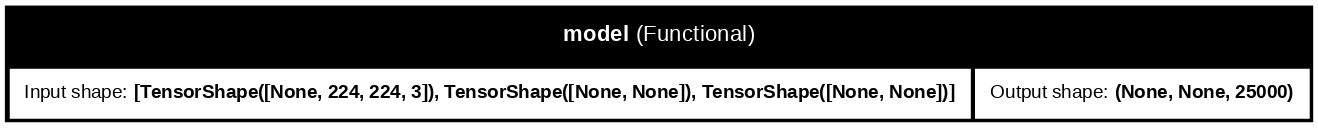

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(full_model,show_shapes=True,show_layer_names=True,expand_nested=True,dpi=100)

# Defining BLEU score metrics

In [36]:
import collections
import math

'''Extracts all n-grams upto a given maximum order from an input segment.
        segment: text segment from which n-grams will be extracted.(a list of tokens)
        max_order: maximum length in tokens of the n-grams returned by this methods.


        returns: The counter containing all n-grams upto max_order in segment
                    with a count of how many times each n-gram occured.
'''
def _get_ngrams(segment,max_order):
    ngram_counts=collections.Counter()
    for order in range(1,max_order+1):
        #slides a window of size order through segment
        for i in range(0,len(segment)-order + 1):
            ngram=tuple(segment[i:i+order])
            ngram_counts[ngram]+=1
    return ngram_counts

In [37]:
# segment = ['the', 'cat', 'sat', 'on', 'the', 'mat']
# max_order = 2
# counter=_get_ngrams(segment, max_order)
# print(counter)


## 🔵 BLEU Score (Bilingual Evaluation Understudy)

BLEU is a metric used to evaluate the quality of text generated by machines, such as translations or captions, by comparing it against one or more reference texts written by humans.

---

## 📐 Mathematical Definition

### 1. Modified n-gram Precision

The precision for n-grams of order $n$ is calculated using the clipped counts:

$$
p_n = \frac{\sum_{\text{ngram} \in \text{candidate}} \min(\text{count}_{\text{candidate}}(\text{ngram}), \max_{r \in \text{references}} \text{count}_r(\text{ngram}))}{\sum_{\text{ngram} \in \text{candidate}} \text{count}_{\text{candidate}}(\text{ngram})}
$$

This avoids overcounting repeated n-grams in the candidate that don't appear as frequently in the references.

---

### 2. Brevity Penalty (BP)

To penalize short candidate sentences:

$$
BP =
\begin{cases}
1 & \text{if } c > r \\
e^{1 - \frac{r}{c}} & \text{if } c \le r
\end{cases}
$$

Where:
- $c$ = length of the candidate sentence  
- $r$ = effective reference length (closest to candidate length)

---

### 3. Final BLEU Score

The BLEU score combines the modified n-gram precisions with the brevity penalty:

$$
\text{BLEU} = BP \cdot \exp\left( \sum_{n=1}^{N} w_n \cdot \log p_n \right)
$$

Where:
- $N$ = maximum n-gram size (typically 4)  
- $w_n$ = weights for each n-gram (usually equal, e.g., $\frac{1}{4}$)  
- $p_n$ = modified precision for n-grams of size $n$

---

## ✅ BLEU Score Example

**Candidate**: `the cat is on the mat`  
**Reference 1**: `there is a cat on the mat`  
**Reference 2**: `the cat is playing on the mat`

### Step 1: n-gram Precisions

- Unigram matches (with clipping): 6/6 → $p_1 = 1.0$  
- Bigram matches: 4/5 → $p_2 = 0.8$

### Step 2: Brevity Penalty

Candidate length $c = 6$, reference length $r = 7$

$$
BP = e^{1 - \frac{7}{6}} = e^{-0.1667} \approx 0.8465
$$

### Step 3: BLEU Score (using 1-gram and 2-gram)

Assume equal weights $w_1 = w_2 = 0.5$

$$
\text{BLEU}_{1,2} = 0.8465 \cdot \exp\left( 0.5 \cdot \log(1.0) + 0.5 \cdot \log(0.8) \right)
$$

$$
= 0.8465 \cdot \exp\left( -0.1116 \right) \approx 0.8465 \cdot 0.894 \approx 0.7569
$$

---

## 📌 Notes

- BLEU ranges from 0 to 1 (higher is better).
- It measures **precision**, not recall.
- More accurate at **corpus level** than sentence level.
- Doesn't consider synonyms or semantics — only exact n-gram overlaps.


In [38]:
"""Computes BLEU score of translated segments against one or more references.

      Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.

      Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """

def compute_bleu(reference_corpus,translation_corpus,max_order=4,smooth=False):
    # how many n-gram matches occured for n=i+1
    matches_by_order = [0] * max_order
    
    #total possible n-grams in translations for n=i+1
    possible_matches_by_order = [0] * max_order

    #total effective reference length
    reference_length = 0

    #total predicted sentence length
    translation_length = 0

    #references: list of ground-truth sentences(all tokenized)
    #translation: the model's predicted sentence(tokenized)
    #BLEU uses the shortest reference length for a fair brevity penalty
    for (references, translation) in zip(reference_corpus,
                                           translation_corpus):
        
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            #|= performs union of n-gram counts: keeps the max count across all references.
            # _get_ngrams returns all n-grams (from 1 to max_order) as Counter.
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)

        #compute n-gram from predicted sentence.
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            #increment match count for the appropriate n-gram length.
            matches_by_order[len(ngram)-1] += overlap[ngram]

        #count how many 1-grams, 2-grams,..., n-grams are possibel in prediction.
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

        #add 1 to numerator and denominator to avoid division by 0.
        precisions = [0] * max_order
        for i in range(0, max_order):
            if smooth:
                   precisions[i] = ((matches_by_order[i] + 1.) /
                           (possible_matches_by_order[i] + 1.))
            else:
                if possible_matches_by_order[i] > 0:
                    precisions[i] = (float(matches_by_order[i]) /
                             possible_matches_by_order[i])
                else:
                    precisions[i] = 0.0

        #BLEU uses the geometric mean of the precisions.
        #If any precision is 0 (no match at that level), geo_mean = 0 (unless smoothed).
        if min(precisions) > 0:
            p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
            geo_mean = math.exp(p_log_sum)
        else:
            geo_mean = 0

        ratio = float(translation_length) / reference_length

        if ratio > 1.0:
            bp = 1.
        else:
            bp = math.exp(1 - 1. / ratio)

        bleu = geo_mean * bp

        return (bleu, precisions, bp, ratio, translation_length, reference_length)

In [39]:

def test_compute_bleu(reference_corpus, translation_corpus, max_order=4, smooth=False):
    matches_by_order = [0] * max_order
    print(f"[Init] matches_by_order: {matches_by_order}")
    
    possible_matches_by_order = [0] * max_order
    print(f"[Init] possible_matches_by_order: {possible_matches_by_order}")
    
    reference_length = 0
    print(f"[Init] reference_length: {reference_length}")
    
    translation_length = 0
    print(f"[Init] translation_length: {translation_length}")

    i = 0
    for (references, translation) in zip(reference_corpus, translation_corpus):
        print(f"\n[Pair {i}] -------------------------------")
        print(f"References: {references}")
        print(f"Translation: {translation}")

        ref_lengths = [len(r) for r in references]
        print(f"[{i}] Reference lengths: {ref_lengths}")
        reference_length += min(ref_lengths)
        print(f"[{i}] Updated reference_length: {reference_length}")

        translation_length += len(translation)
        print(f"[{i}] Updated translation_length: {translation_length}")

        # Merging all reference n-gram counts
        merged_ref_ngram_counts = collections.Counter()
        for j, reference in enumerate(references):
            ref_ngrams = _get_ngrams(reference, max_order)
            merged_ref_ngram_counts |= ref_ngrams
            print(f"[{i}.{j}] Reference {j} ngrams: {ref_ngrams}")
        print(f"[{i}] Merged reference n-gram counts: {merged_ref_ngram_counts}")

        translation_ngram_counts = _get_ngrams(translation, max_order)
        print(f"[{i}] Translation n-gram counts: {translation_ngram_counts}")

        overlap = translation_ngram_counts & merged_ref_ngram_counts
        print(f"[{i}] Overlap n-grams: {overlap}")

        for ngram in overlap:
            matches_by_order[len(ngram) - 1] += overlap[ngram]
        print(f"[{i}] Updated matches_by_order: {matches_by_order}")

        for order in range(1, max_order + 1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order - 1] += possible_matches
        print(f"[{i}] Updated possible_matches_by_order: {possible_matches_by_order}")
        
        i += 1

    precisions = [0] * max_order
    for i in range(max_order):
        if smooth:
            precisions[i] = (matches_by_order[i] + 1.0) / (possible_matches_by_order[i] + 1.0)
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = float(matches_by_order[i]) / possible_matches_by_order[i]
            else:
                precisions[i] = 0.0
    print(f"\n[Final] Precisions by order: {precisions}")

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0.0
    print(f"[Final] Geometric mean of precisions: {geo_mean}")

    ratio = float(translation_length) / reference_length
    print(f"[Final] Length ratio (translation/ref): {ratio}")

    if ratio > 1.0:
        bp = 1.0
    else:
        bp = math.exp(1 - 1. / ratio)
    print(f"[Final] Brevity Penalty (bp): {bp}")

    bleu = geo_mean * bp
    print(f"[Final] BLEU score: {bleu}")

    return (bleu, precisions, bp, ratio, translation_length, reference_length)


In [40]:
reference_corpus = [
    [["the", "cat", "is", "on", "the", "mat"]],   # 1 reference sentence
    [["there", "is", "a", "cat", "on", "the", "mat"]]  # another reference sentence
]

translation_corpus = [
    ["the", "cat", "sat", "on", "the", "mat"],   # predicted sentence 1
    ["there", "is", "cat", "on", "mat"]          # predicted sentence 2
]


In [41]:
bleu_result=test_compute_bleu(reference_corpus,translation_corpus,smooth=True)

[Init] matches_by_order: [0, 0, 0, 0]
[Init] possible_matches_by_order: [0, 0, 0, 0]
[Init] reference_length: 0
[Init] translation_length: 0

[Pair 0] -------------------------------
References: [['the', 'cat', 'is', 'on', 'the', 'mat']]
Translation: ['the', 'cat', 'sat', 'on', 'the', 'mat']
[0] Reference lengths: [6]
[0] Updated reference_length: 6
[0] Updated translation_length: 6
[0.0] Reference 0 ngrams: Counter({('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1, ('the', 'cat'): 1, ('cat', 'is'): 1, ('is', 'on'): 1, ('on', 'the'): 1, ('the', 'mat'): 1, ('the', 'cat', 'is'): 1, ('cat', 'is', 'on'): 1, ('is', 'on', 'the'): 1, ('on', 'the', 'mat'): 1, ('the', 'cat', 'is', 'on'): 1, ('cat', 'is', 'on', 'the'): 1, ('is', 'on', 'the', 'mat'): 1})
[0] Merged reference n-gram counts: Counter({('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1, ('the', 'cat'): 1, ('cat', 'is'): 1, ('is', 'on'): 1, ('on', 'the'): 1, ('the', 'mat'): 1, ('the', 'cat', 'is'): 1, ('cat', '

In [42]:
class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
        """ Computes the BLEU score (Metric for machine translation) """
        super().__init__()
        self.tokenizer = tokenizer
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        #takes the most probable token at each time step.
        # "pred" is expected to be a tensor of shape (batch_size, seq_len,vocab_size).
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and other tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "\[END\].*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu


# Training the model

In [43]:
# from tqdm import tqdm
# batch_size=32

# bleu_metric = BLEUMetric(tokenizer=tokenizer)


# for e in range(15):
#     print(f"Epoch: {e+1}")
    
#     train_dataset, _ = generate_tf_dataset(
#         train_data, n_vocab=vocab_length, batch_size=batch_size, training=True
#     )
#     valid_dataset, _ = generate_tf_dataset(
#         validation_data, n_vocab=vocab_length, batch_size=batch_size, training=False
#     )
    
#     full_model.fit(
#         train_dataset,
#         epochs=1
#     )
    
#     valid_loss, valid_accuracy, valid_bleu = [], [], []
#     for v_batch in tqdm(valid_dataset):
#         loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
#         batch_predicted = full_model(v_batch[0])
#         bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
#         valid_loss.append(loss)
#         valid_accuracy.append(accuracy)
#         valid_bleu.append(bleu_score)
        
#     print(
#         f"\nvalid_loss: {np.mean(valid_loss)} - valid_accuracy: {np.mean(valid_accuracy)} - valid_bleu: {np.mean(valid_bleu)}"
#     )

In [44]:
# from tqdm import tqdm

# batch_size = 2
# epochs = 5
# best_bleu = 0.0  # Track best BLEU score
# bleu_metric = BLEUMetric(tokenizer=tokenizer)
# checkpoint_path = "best_bleu_model.h5"

# for e in range(epochs):
#     print(f"\nEpoch {e+1}/{epochs}")
    
#     # Generate train and validation datasets
#     train_dataset, _ = generate_tf_dataset(
#         train_data, n_vocab=vocab_length, batch_size=batch_size, training=True
#     )
#     valid_dataset, _ = generate_tf_dataset(
#         validation_data, n_vocab=vocab_length, batch_size=batch_size, training=False
#     )
    
#     # Train model for one epoch
#     full_model.fit(train_dataset, epochs=1)

#     # Collect predictions and ground truths from validation set
#     all_preds, all_reals = [], []
#     valid_loss, valid_accuracy = [], []

#     print("Evaluating on validation set:")
#     for v_batch in tqdm(valid_dataset):
#         # v_batch[0] = input_data (X)  → e.g., tokenized captions, image features, etc.
#         # v_batch[1] = target_data (Y) → e.g., expected output tokens (ground truth).
#         loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
#         preds = full_model.predict_on_batch(v_batch[0])

#         valid_loss.append(loss)
#         valid_accuracy.append(accuracy)
#         all_preds.append(preds)
#         all_reals.append(v_batch[1])

#     # Combine all predictions and references
#     all_preds = tf.concat(all_preds, axis=0)
#     all_reals = tf.concat(all_reals, axis=0)

#     # Calculate BLEU score for the entire validation set
#     bleu_score = bleu_metric.calculate_bleu_from_predictions(all_reals, all_preds)

#     print(f"\nValidation Loss: {np.mean(valid_loss):.4f}")
#     print(f"Validation Accuracy: {np.mean(valid_accuracy):.4f}")
#     print(f"Validation BLEU Score: {bleu_score:.4f}")

#     # Save model if BLEU is best so far
#     if bleu_score > best_bleu:
#         best_bleu = bleu_score
#         full_model.save_weights(checkpoint_path)
#         print(f"✅ Saved new best model with BLEU: {best_bleu:.4f} to {checkpoint_path}")


In [45]:
import os
from tqdm import tqdm
best_bleu = -1.0
checkpoint_path = "/kaggle/working/best_model_checkpoint.keras"
batch_size = 32
bleu_metric = BLEUMetric(tokenizer=tokenizer)

for e in range(15):
    print(f"Epoch: {e+1}")
    
    train_dataset, _ = generate_tf_dataset(
        train_data, n_vocab=vocab_length, batch_size=batch_size, training=True
    )
    valid_dataset, _ = generate_tf_dataset(
        validation_data, n_vocab=vocab_length, batch_size=batch_size, training=False
    )
    
    full_model.fit(train_dataset, epochs=1)
    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for v_batch in tqdm(valid_dataset):
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        
    mean_loss = np.mean(valid_loss)
    mean_accuracy = np.mean(valid_accuracy)
    mean_bleu = np.mean(valid_bleu)

    print(f"\nvalid_loss: {mean_loss} - valid_accuracy: {mean_accuracy} - valid_bleu: {mean_bleu}")

    if mean_bleu > best_bleu:
        print(f"New best BLEU score: {mean_bleu:.4f}, saving model...")
        best_bleu = mean_bleu

        # Ensure the file doesn't exist, then save
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
        
        full_model.save(checkpoint_path)
        print(f"Best model saved !!")


Epoch: 1
4470/4470 [==============================] - 1423s 274ms/step - loss: 1.8255 - accuracy: 0.7022


100%|██████████| 249/249 [11:27<00:00,  2.76s/it]



valid_loss: 1.6490508935537682 - valid_accuracy: 0.715118330645274 - valid_bleu: 0.01677536363386564
New best BLEU score: 0.0168, saving model...
Best model saved !!
Epoch: 2
4470/4470 [==============================] - 1220s 273ms/step - loss: 1.5832 - accuracy: 0.7199


100%|██████████| 249/249 [10:48<00:00,  2.60s/it]



valid_loss: 1.5667614285725666 - valid_accuracy: 0.7218093800257488 - valid_bleu: 0.02452600494212935
New best BLEU score: 0.0245, saving model...
Best model saved !!
Epoch: 3
4470/4470 [==============================] - 1226s 274ms/step - loss: 1.5271 - accuracy: 0.7231


100%|██████████| 249/249 [10:51<00:00,  2.62s/it]



valid_loss: 1.5416273668587925 - valid_accuracy: 0.7237987685873806 - valid_bleu: 0.02171644934136362
Epoch: 4
4470/4470 [==============================] - 1221s 273ms/step - loss: 1.5137 - accuracy: 0.7228


100%|██████████| 249/249 [10:48<00:00,  2.60s/it]



valid_loss: 1.6513083019409793 - valid_accuracy: 0.7104195349187736 - valid_bleu: 0.021688280497496642
Epoch: 5
4470/4470 [==============================] - 1221s 273ms/step - loss: 1.4919 - accuracy: 0.7235


100%|██████████| 249/249 [10:56<00:00,  2.63s/it]



valid_loss: 1.5348090254159337 - valid_accuracy: 0.7239479334000124 - valid_bleu: 0.02874430157910726
New best BLEU score: 0.0287, saving model...
Best model saved !!
Epoch: 6
4470/4470 [==============================] - 1242s 278ms/step - loss: 1.5121 - accuracy: 0.7201


100%|██████████| 249/249 [11:03<00:00,  2.66s/it]



valid_loss: 1.5638339744514251 - valid_accuracy: 0.721842368443807 - valid_bleu: 0.02393493768272438
Epoch: 7
4470/4470 [==============================] - 1235s 276ms/step - loss: 1.5055 - accuracy: 0.7204


100%|██████████| 249/249 [10:44<00:00,  2.59s/it]



valid_loss: 1.5558132253976231 - valid_accuracy: 0.7228571427873818 - valid_bleu: 0.024571286940348342
Epoch: 8
4470/4470 [==============================] - 1218s 272ms/step - loss: 1.5126 - accuracy: 0.7186


100%|██████████| 249/249 [10:46<00:00,  2.60s/it]



valid_loss: 1.575817536158734 - valid_accuracy: 0.7192656309250368 - valid_bleu: 0.025276106346570505
Epoch: 9
4470/4470 [==============================] - 1222s 273ms/step - loss: 1.4839 - accuracy: 0.7208


100%|██████████| 249/249 [10:47<00:00,  2.60s/it]



valid_loss: 1.5573012508062953 - valid_accuracy: 0.7219205410126223 - valid_bleu: 0.02718957703676861
Epoch: 10
4470/4470 [==============================] - 1219s 273ms/step - loss: 1.4378 - accuracy: 0.7254


100%|██████████| 249/249 [10:40<00:00,  2.57s/it]



valid_loss: 1.528832836802226 - valid_accuracy: 0.7253270221043782 - valid_bleu: 0.02432006311185281
Epoch: 11
4470/4470 [==============================] - 1222s 273ms/step - loss: 1.4214 - accuracy: 0.7264


100%|██████████| 249/249 [10:45<00:00,  2.59s/it]



valid_loss: 1.528978501936518 - valid_accuracy: 0.7254331605022691 - valid_bleu: 0.02883523044949821
New best BLEU score: 0.0288, saving model...
Best model saved !!
Epoch: 12
4470/4470 [==============================] - 1228s 275ms/step - loss: 1.4112 - accuracy: 0.7270


100%|██████████| 249/249 [11:23<00:00,  2.75s/it]



valid_loss: 1.572795142610389 - valid_accuracy: 0.7201506023904884 - valid_bleu: 0.020403128815499483
Epoch: 13
4470/4470 [==============================] - 1249s 279ms/step - loss: 1.4203 - accuracy: 0.7248


100%|██████████| 249/249 [11:17<00:00,  2.72s/it]



valid_loss: 1.5282578013508195 - valid_accuracy: 0.7256712564024101 - valid_bleu: 0.027539787190156963
Epoch: 14
4470/4470 [==============================] - 1225s 274ms/step - loss: 1.4106 - accuracy: 0.7254


100%|██████████| 249/249 [10:44<00:00,  2.59s/it]



valid_loss: 1.5327784531566513 - valid_accuracy: 0.7257264773529696 - valid_bleu: 0.027501257803755372
Epoch: 15
4470/4470 [==============================] - 1228s 275ms/step - loss: 1.3841 - accuracy: 0.7283


100%|██████████| 249/249 [10:51<00:00,  2.62s/it]


valid_loss: 1.5351993381737705 - valid_accuracy: 0.7253370646492066 - valid_bleu: 0.020820048642813883


In [46]:
bleu_metric = BLEUMetric(tokenizer=tokenizer)

test_dataset, _ = generate_tf_dataset(
    test_data,  n_vocab=vocab_length, batch_size=batch_size, training=False
)

test_loss, test_accuracy, test_bleu = [], [], []
for ti, t_batch in enumerate(test_dataset):
    print(f"{ti+1} batches processed", end='\r')
    loss, accuracy = full_model.test_on_batch(t_batch[0], t_batch[1])
    batch_predicted = full_model.predict_on_batch(t_batch[0])
    bleu_score = bleu_metric.calculate_bleu_from_predictions(t_batch[1], batch_predicted)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    test_bleu.append(bleu_score)

print(
    f"\ntest_loss: {np.mean(test_loss)} - test_accuracy: {np.mean(test_accuracy)} - test_bleu: {np.mean(test_bleu)}"
)

249 batches processed
test_loss: 1.5473129888136223 - test_accuracy: 0.7243947231147184 - test_bleu: 0.017410614974337633


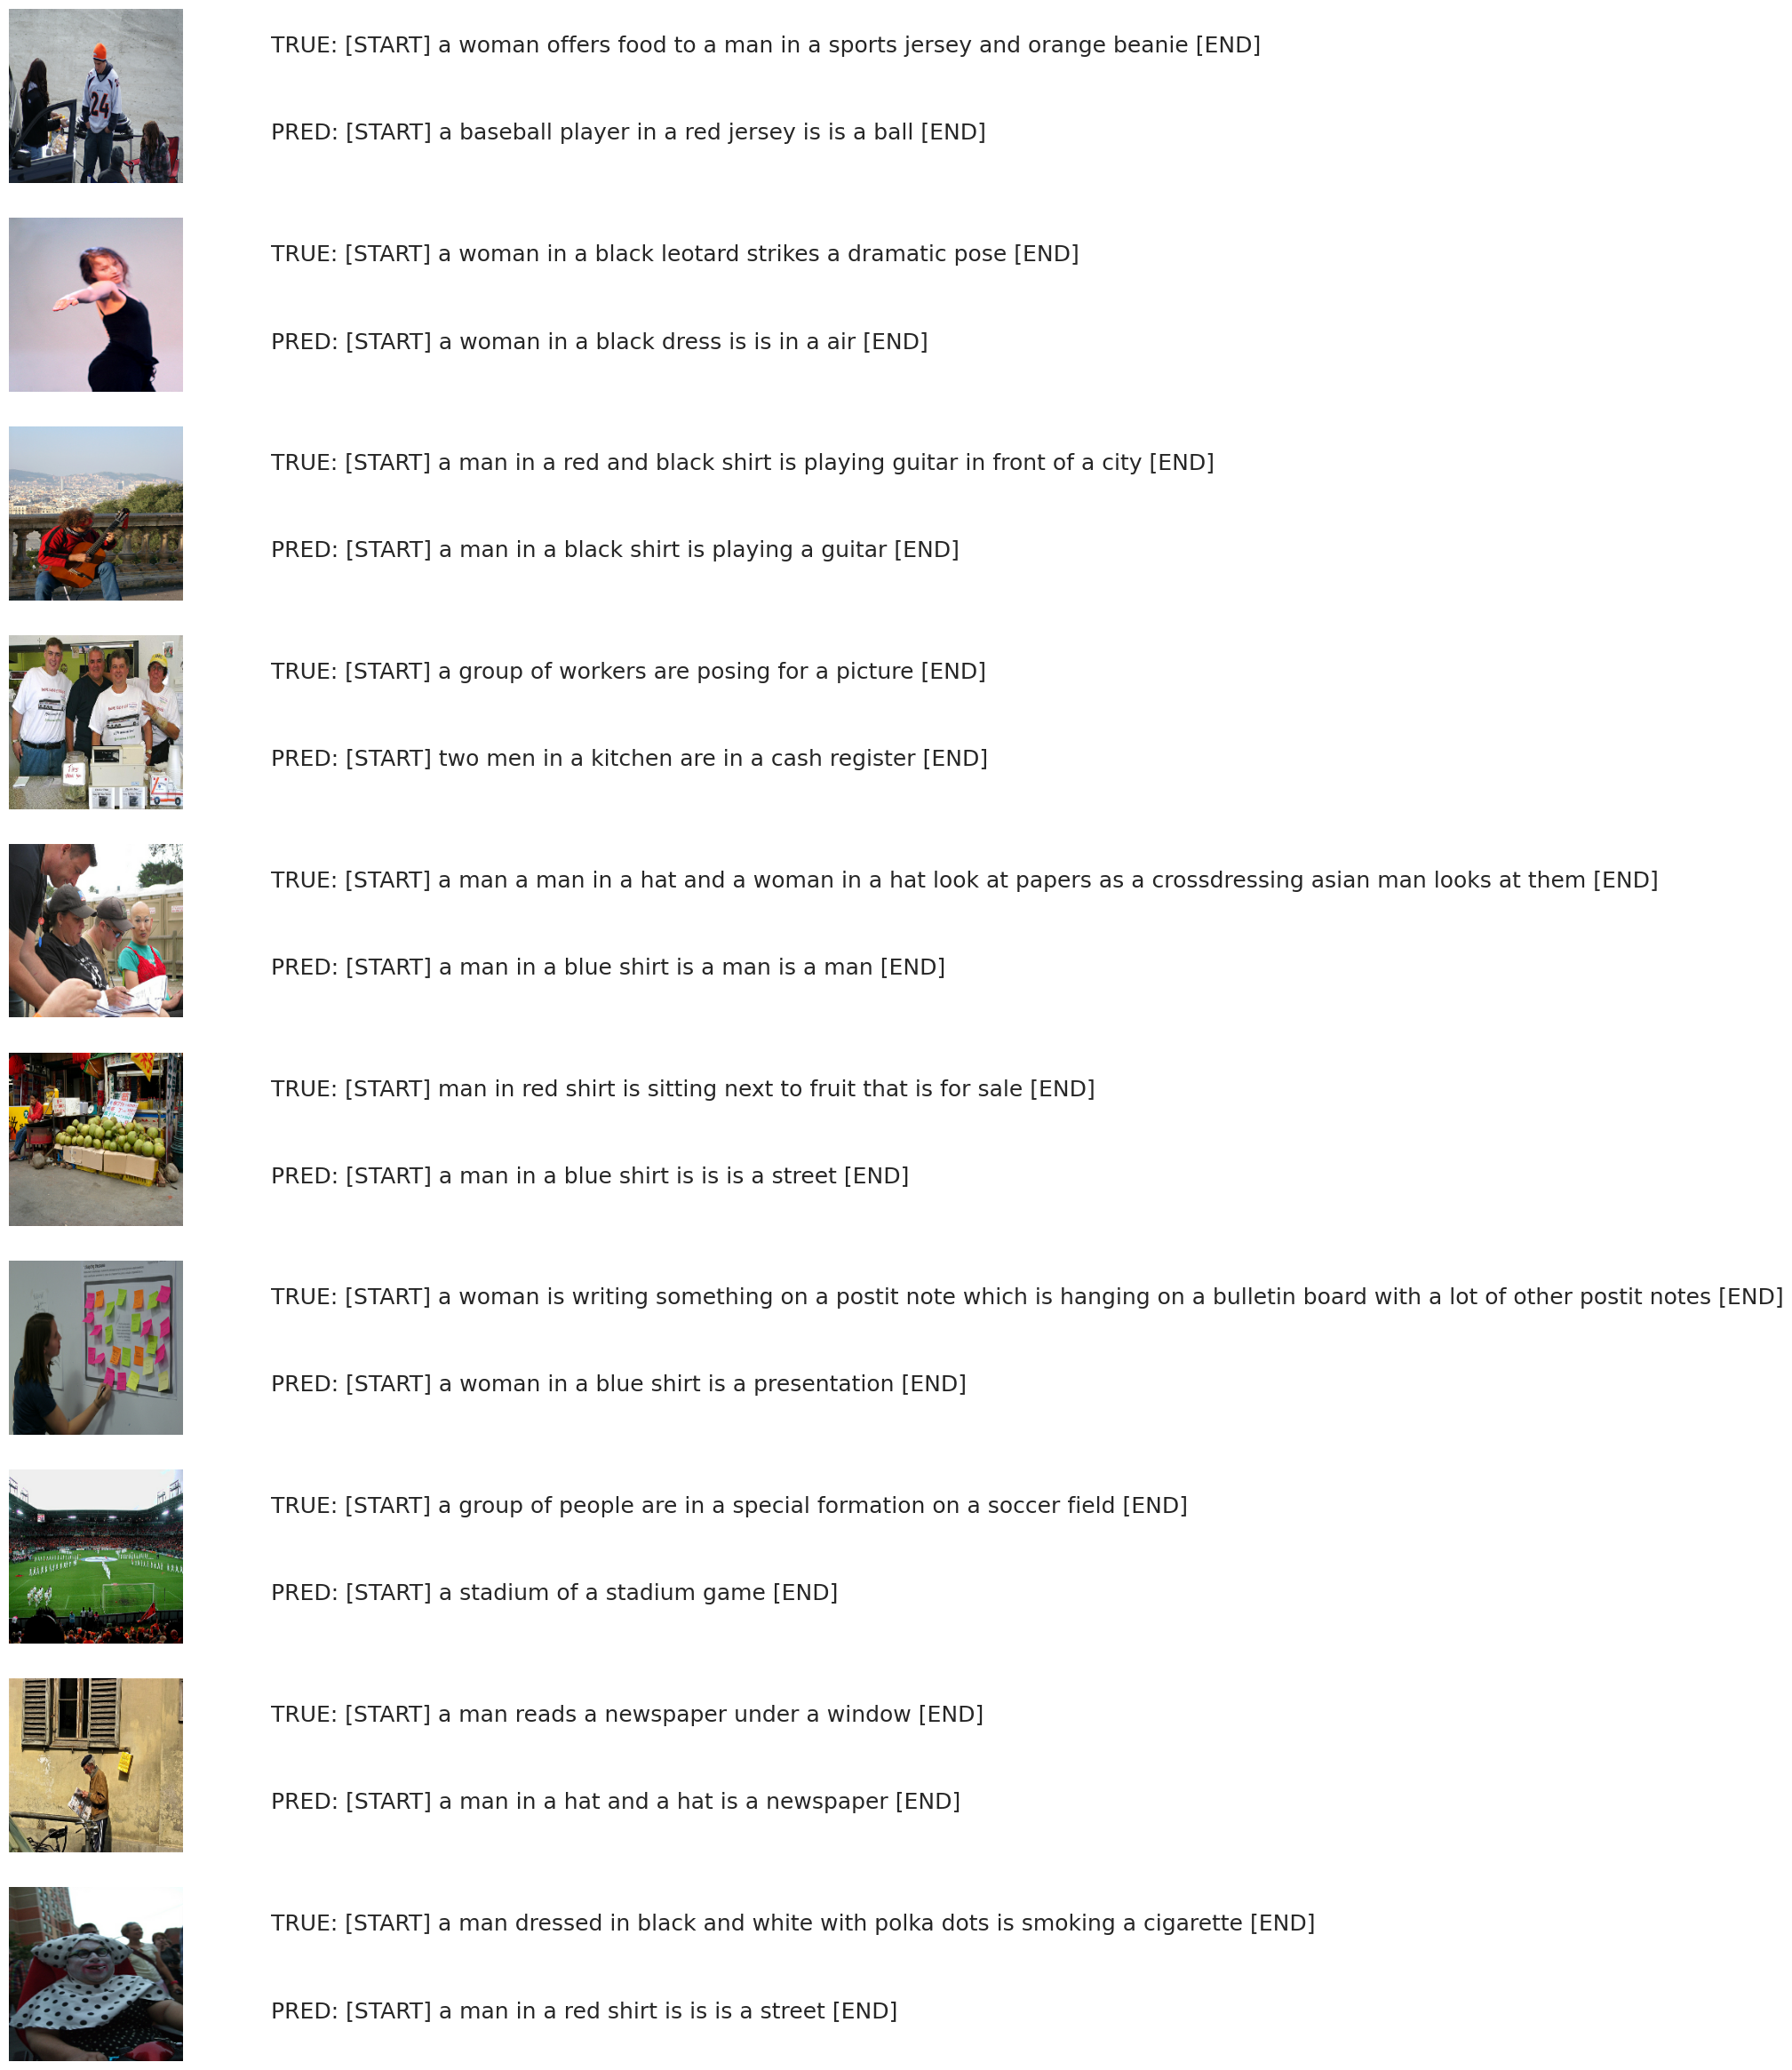

In [47]:
n_samples = 10
test_dataset, _ = generate_tf_dataset(
    test_data.sample(n=n_samples), n_vocab=vocab_length, batch_size=n_samples, training=False
)

def generate_caption(model, image_input, tokenizer, n_samples):
    # 2 -> [START]
    batch_tokens = np.repeat(np.array([[2]]), n_samples, axis=0)
    
    for i in range(30):
        if np.all(batch_tokens[:,-1] == 3):
            break
            
        position_input = tf.repeat(tf.reshape(tf.range(i+1),[1,-1]), n_samples, axis=0)
        probs = full_model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        sample_predicted_token_ids = sample_tokens.ravel()
        sample_predicted_tokens = []
        for wid in sample_predicted_token_ids:
            sample_predicted_tokens.append(tokenizer.id_to_token(wid))
            if wid == 3:
                break
        sample_predicted_text = " ".join([tok for tok in sample_predicted_tokens])
        sample_predicted_text = sample_predicted_text.replace(" ##", "")
        predicted_text.append(sample_predicted_text)
    
    return predicted_text
    
    
for batch in test_dataset.take(1):
    (batch_image_input, _, _), batch_true_caption = batch

batch_predicted_text = generate_caption(full_model, batch_image_input, tokenizer, n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize=(8,30))

for i,(sample_image_input, sample_true_caption, sample_predicated_caption) in enumerate(zip(batch_image_input, batch_true_caption, batch_predicted_text)):
    
    sample_true_caption_tokens  = [tokenizer.id_to_token(wid) for wid in sample_true_caption.numpy().ravel()]
    
    sample_true_text = []
    for tok in sample_true_caption_tokens:
        sample_true_text.append(tok)
        if tok == '[END]':
            break
    
    sample_true_text = " ".join(sample_true_text).replace(" ##", "")
    axes[i][0].imshow(((sample_image_input.numpy()+1.0)/2.0))
    axes[i][0].axis('off')
    
    true_annotation = f"TRUE: {sample_true_text}"
    predicted_annotation = f"PRED: {sample_predicated_caption}"
    axes[i][1].text(0, 0.75, true_annotation, fontsize=18)
    axes[i][1].text(0, 0.25, predicted_annotation, fontsize=18)
    axes[i][1].axis('off')